In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import GammaPrior
from edbo.bro import BO

%matplotlib inline

In [30]:
from data_loader import suzuki, casp

test_casp = casp()

test_suzuki = suzuki(electrophile='dft',                 # dft, mordred, or ohe
                     nucleophile='dft',                  # dft, mordred, or ohe
                     base='dft',                         # dft, mordred, or ohe
                     ligand='boltzmann-dft',             # random-dft, boltzmann-dft, mordred, or ohe
                     solvent='dft')                      # dft, mordred, or ohe

#print("Suzuki Returns: ")
#print(test_suzuki)

#print("Casp Returns: ")
#print(test_casp)


C:\Users\lucap\Desktop\Uni\Postgrad\1st Term (Michaelmas)\L48 Machine Learning and The Physical World\Project\l48-project\code\data_loader.py:190: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  experiment_index['yield'] = index['yield']


### Data Preprocessing

In [33]:
from edbo.utils import Data
from data_loader import suzuki, casp

casp = Data(casp()) # load casp data

casp.drop(['F1', 'F2']) # drop unwanted columns (do after sensitivity analysis)

print(casp.data)

# Standardize (normalize, etc)
casp.standardize(target='RMSD', scaler='standard')

# Drop highly correlated features
casp.uncorrelated(target='RMSD', threshold=0.95)

print(casp.data)

         RMSD        F1       F2       F3        F4            F5        F6  \
0      17.284  13558.30  4305.35  0.31754  162.1730  1.872791e+06  215.3590   
1       6.021   6191.96  1623.16  0.26213   53.3894  8.034467e+05   87.2024   
2       9.275   7725.98  1726.28  0.22343   67.2887  1.075648e+06   81.7913   
3      15.851   8424.58  2368.25  0.28111   67.8325  1.210472e+06  109.4390   
4       7.962   7460.84  1736.94  0.23280   52.4123  1.021020e+06   94.5234   
...       ...       ...      ...      ...       ...           ...       ...   
45725   3.762   8037.12  2777.68  0.34560   64.3390  1.105797e+06  112.7460   
45726   6.521   7978.76  2508.57  0.31440   75.8654  1.116725e+06  102.2770   
45727  10.356   7726.65  2489.58  0.32220   70.9903  1.076560e+06  103.6780   
45728   9.791   8878.93  3055.78  0.34416   94.0314  1.242266e+06  115.1950   
45729  18.827  12732.40  4444.36  0.34905  157.6300  1.788897e+06  229.4590   

            F7   F8       F9  
0      4287.87  102 

### Bayesian Optimization

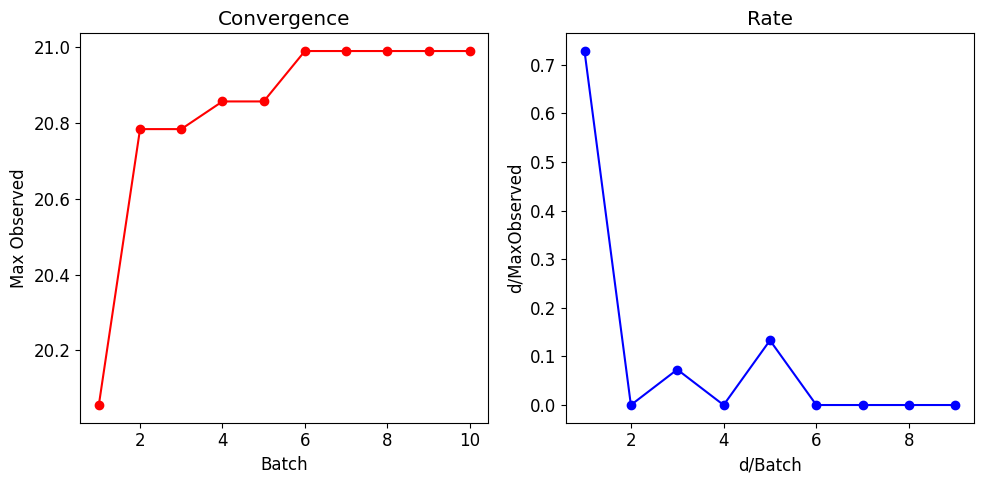

In [38]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp.data,                      # Experiment index to look up results from
        domain=casp.data.drop('RMSD', axis=1),  # Reaction space
        batch_size=12,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='EI',              # Use expected improvement
        fast_comp=True)                         # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

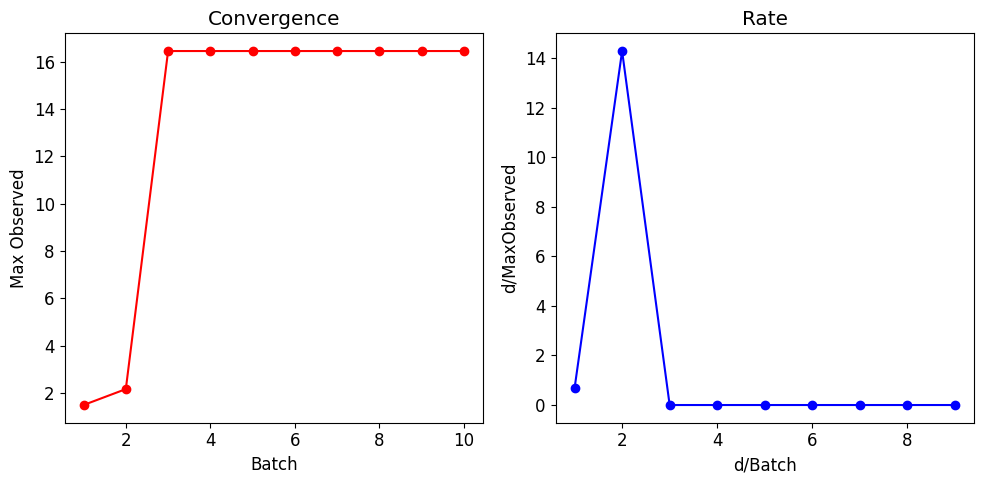

In [40]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp.data,                      # Experiment index to look up results from
        domain=casp.data.drop('RMSD', axis=1),  # Reaction space
        batch_size=1,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',              # Use expected improvement
        fast_comp=True)                        # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

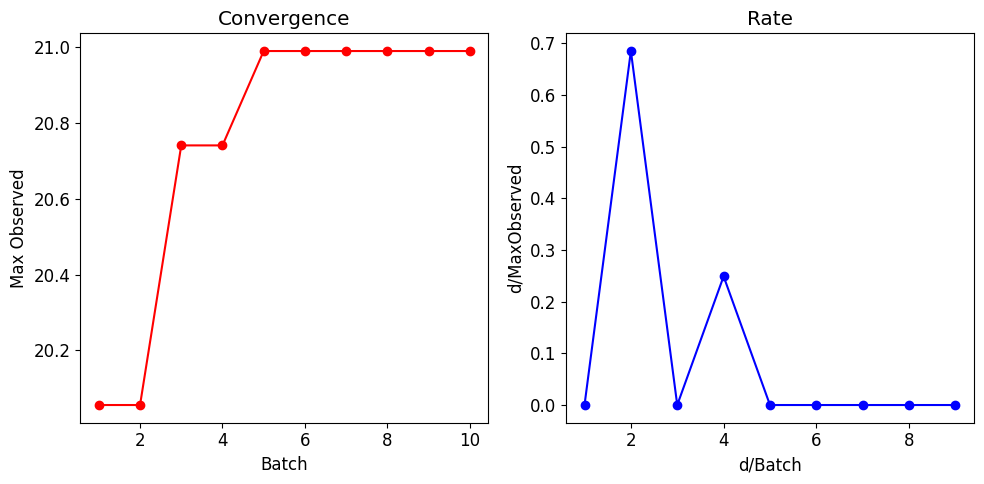

In [41]:
from edbo.bro import BO

# TODO: play around with the surrogate model and use to instantiate BO

# Instantiate edbo.bro.BO
bo = BO(exindex=casp.data,                      # Experiment index to look up results from
        domain=casp.data.drop('RMSD', axis=1),  # Reaction space
        batch_size=20,                          # Choose 20 experiments on each iteraiton 
        acquisition_function='TS',              # Use expected improvement
        fast_comp=True)                         # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

### Simulations

In [42]:
from edbo.models import GP_Model, RF_Model, Random
from edbo.plot_utils import average_convergence, plot_avg_convergence
import pandas as pd

# Function for simulating different BO parameters

def simulate(data,                 # Data container (vide supra)
             acq_func,             # Acquisition function: 'EI', 'PI', 'UCB', 'TS', ...
             model=GP_Model,       # Surrogate model: GP_Model or RF_Model
             init_method='rand',   # Initialization method: 'rand', 'pam', 'kmeans'
             batch_size=5,         # Parallel acquisition: int
             iterations=9,         # Number of iterations to run each simulation for
             average_of=10,        # Number of simulations to average
             export_path=None,     # Export the simulation results to a CSV file
             plot=False):          # Plot the average and standard deviation averaged convergence
    """
    Simulation function which averages BO runs with given optimization paramters.
    """
    
    # Average N optimizations with different random initializations
    results = []
    for i in range(average_of):
        
        # Use random function if the acquisition function is random selection
        if acq_func == 'rand':
            bo = BO(exindex=data.data,
                    domain=data.data.drop('RMSD', axis=1),
                    init_method=init_method,
                    model=Random,
                    batch_size=batch_size,
                    acquisition_function=acq_func)
        # Otherwise use specified model
        else:
            bo = BO(exindex=data.data,
                    domain=data.data.drop('RMSD', axis=1),
                    model=model,
                    init_method=init_method,
                    batch_size=batch_size,
                    acquisition_function=acq_func,
                    fast_comp=True)                            # Use gpytorch fast computation features
            
        # Simulate
        bo.init_seq.visualize = False
        bo.simulate(iterations=iterations, seed=i)
        
        # Append results to record
        results.append(bo.obj.results_input()['RMSD'].values)
        
    # Save the results to a CSV file
    results = pd.DataFrame(results)
    if export_path != None:
        results.to_csv(export_path)
        
    # Average performance
    index, mean, std = average_convergence(results, batch_size)
    
    # Plot
    if plot:
        plot_avg_convergence(results, batch_size)
        
    return results, mean, std

Acquisition Function: EI


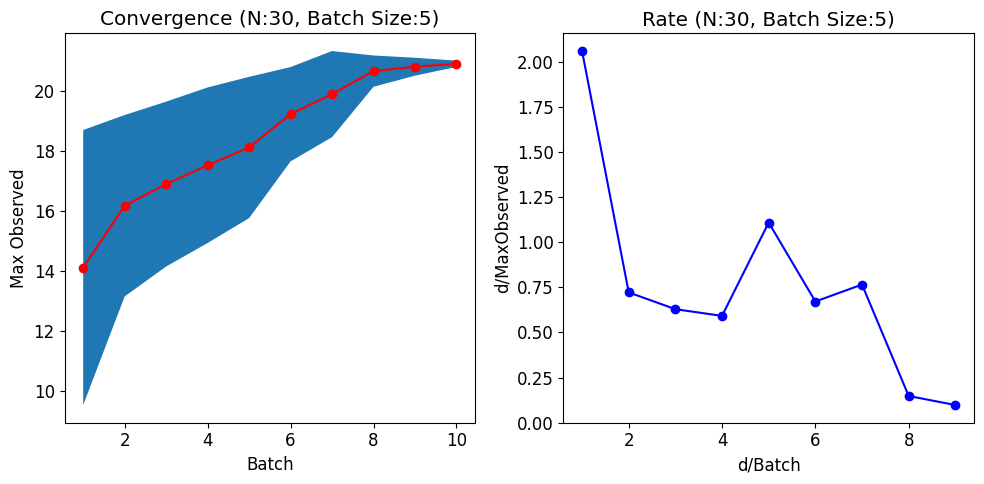

Acquisition Function: TS


In [ ]:
from edbo.plot_utils import compare_convergence

# Simulation

acq_funcs = ['EI', 'TS', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(casp,            # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=5,        # Choose 5 experiments at a time
                              iterations=9,        # Run for 9 iterations
                              average_of=30,       # Run with 30 different random seeds
                              export_path=None,    # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 5, acq_funcs)

#### Ideas

- Visualise the surrogate model space (posterior) after certain numbers of iterations to show exploration/exploitation
- Visualise the separation of the data in space for a few features